 # Suzuki Mileage
 *An analysis of 5 years of gas fill up logs of a 1996 Suzuki Sidekick*
 ### Backstory
 My father kept a little paper notebook in each of the family cars where he would write down the date, odometer, trip meter, and gallons of each gas fill up. He would also write down maintenance like oil and spark plugs changes.

 My friends used to ask, *why do you write down this stuff down?* when I was getting gas.

 Maybe writing down the odometer of the last oil change would keep you from needing an unsightly Jiffy Lube sticker on your windshield. Or knowing that the spark plugs were 2 year old when the engine didn't feel *quite* right.

 Maybe you'd be able to see that the mileage was slowly going down, telling you it was time for a tune up or to add some air to the tires.

 Eventually I started using an iPhone app called [Road Trip](http://darrensoft.ca/roadtrip) to log my fill ups and maintenance. I logged data in Road Trip for over 5 years before exporting it as a .csv.

 ### Goals

 1. Determine any seasonality of mileage

 I was convinced that cars get worse mileage in the winter, particularly after learning about oxygenated gas -- does the data support this? Wouldn't running the air conditioner in the summer drag the mileage down further? So many questions!

 2. Interview take home project

 In a past job, I needed to hire someone in the data analytics / engineering / science space and was lacking a take home project equivalent to what we were giving to software engineers. Before I can send this (truly unique) data to anyone, I have to dig through it myself.

 3. Learning / mentoring / sharing

 I like to learn and mentor using real world problems and data. This .csv should be perfect for some light to moderate Python, pandas, and matplotlib. I also wanted to brush up on my own statistics, modeling, and data science skills.

 These are what led me to sharing this story, data, and python / Jupyter notebook! Let's dig in.

 ### Importing

 What packages will we be working with?

 1. **pandas**: how would I describe pandas in my own words? Dataframes for Python? A way to work with .csv data in Python? pandas self describes as: a data analysis library for Python
 2. **numpy**: scientific computing package for Python
 3. **scipy.stats**: the statistics portion of a scientific computing Python library. We'll just pull in the linear regression module
 4. **matplotlib**: a highly criticized data visualization library, reminiscent of plotting in MATLAB
 5. **geopandas**: *pandas but for geographic data*
 6. **shapely**: Python geometry analysis package

In [1]:

import pandas as pd
import numpy as np

from scipy.stats import linregress

import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point


 ### User variables

 After imports, I like to define some user variables. Here I define the name of the .csv file I will import, some figure size and font settings for matplotlib, and plot axis limits.

 I also define lj_home, sf_home, and sd_home to be my La Jolla, San Francisco, and San Diego home latitude / longitude. They are converted into a projected cartesian system with X and Y coordinates. This makes it easier to calculate distance between two points.

In [2]:


file_in = "Suzuki Sidekick Sport MAR2022.csv"

fig_size = (8, 4.5)
fig_size_geo = (510, 800)
plt.rc("font", size=10)

mpg_lim = [12, 27]

km_in_mi = 0.62137
m_in_km = 1000

# La Jolla home lat, lon
lj_home = Point(-117.25, 32.85)
lj_df = gpd.GeoDataFrame({"geometry": [lj_home]}, crs="EPSG:4326")
lj_df = lj_df.to_crs(epsg=32663)
lj_home = lj_df.iloc[0].geometry
del lj_df

# San Francisco home lat, lon
# project to EPSG-32663 using geopandas df
sf_home = Point(-122.422, 37.770)
sf_df = gpd.GeoDataFrame({"geometry": [sf_home]}, crs="EPSG:4326")
sf_df = sf_df.to_crs(epsg=32663)
sf_home = sf_df.iloc[0].geometry
del sf_df

# San Diego home lat, lon
sd_home = Point(-117.075, 33.025)
sd_df = gpd.GeoDataFrame({"geometry": [sd_home]}, crs="EPSG:4326")
sd_df = sd_df.to_crs(epsg=32663)
sd_home = sd_df.iloc[0].geometry
del sd_df


## User functions

 I needed a place to put a function that converted meters into miles which is used in the distance calculation.

In [3]:


def m_to_mi(meters_in):
    return meters_in * km_in_mi / m_in_km



 ### Importing the .csv

 The .csv generated by *Road Trip* has some header information before the column names and actual data.

 The default behavior of `read_csv` is to skip empty lines `(skip_empty_line = True)` so we want to tell `read_csv` that the column names are on line 4 (starting at 0). Here is the first few lines of the csv:

 ```
 ROAD TRIP CSV ",."
 Version,Language
 1500,en


 FUEL RECORDS
 Odometer (mi),Trip Distance,Date,Fill Amount,Fill Units,Price per Unit,Total Price,Partial Fill,MPG,Note,Octane,Location,Payment,Conditions,Reset,Categories,Flags,Currency Code,Currency Rate,Latitude,Longitude,ID,Trip Comp Fuel Economy,Trip Comp Avg. Speed,Trip Comp Temperature,Trip Comp Drive Time,Tank Number
 231520,,"2016-12-11 11:21",11.2,Gal,2.8777,32.23,,,,,,,,Reset,,9,,1,,,1,,,,,0
 ```

 We read the .csv into a *pandas dataframe*, which is printed as a neat table below (and frequently in my notebooks).

In [4]:

# this varies where the actual table starts in the .csv file
# skip_empty_lines is True by default, and we start counting at 0, so our column names are in line 4
col_names_row = 4

# read and print df
df = pd.read_csv(file_in, header=col_names_row)
df


,Odometer (mi),Trip Distance,Date,Fill Amount,Fill Units,Price per Unit,Total Price,Partial Fill,MPG,Note,...,Currency Code,Currency Rate,Latitude,Longitude,ID,Trip Comp Fuel Economy,Trip Comp Avg. Speed,Trip Comp Temperature,Trip Comp Drive Time,Tank Number
0,231520,NaN,2016-12-11 11:21,11.2,Gal,2.8777,32.23,NaN,NaN,NaN,...,NaN,1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0
1,231729,209,2016-12-16,10.7,Gal,2.8963,30.99,NaN,19.5327,NaN,...,NaN,1,NaN,NaN,2.0,NaN,NaN,NaN,NaN,0.0
2,231932,203,2016-12-27 11:16,11.2,Gal,3.0893,34.6,NaN,18.125,NaN,...,NaN,1,32.836524,-117.152631,4.0,NaN,NaN,NaN,NaN,0.0
3,232141,209,2016-12-31 19:49,10.9,Gal,3.1872,34.74,NaN,19.1743,NaN,...,NaN,1,32.838751,-117.278172,6.0,NaN,NaN,NaN,NaN,0.0
4,232336,195,2017-1-8 17:20,10.1,Gal,3.2139,32.46,NaN,19.3069,NaN,...,NaN,1,32.832988,-117.163933,8.0,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,TIRE LOG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272,Name,Start Date,Start Odometer (mi.),Size,Size Correction,Distance,Age,Note,Flags,ID,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273,Default Tires,NaN,NaN,NaN,NaN,43540,5 years 8 months,NaN,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274,VALUATIONS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 ### Column naming and dropping

 In *pandas* we operate on column names frequently, so they should have clean names. It's best not to use spaces or other symbols, and I prefer to avoid capital letters.

 We can set the dataframe to include only the columns we renamed, effectively dropping the rest.

 We'll keep:

 1. **date:** datetime of fill up
 2. **odometer:** total miles on vehicle
 3. **trip:** miles since last fill up
 4. **gallons:** amount of fuel vehicle filled with (US gallons)
 5. **price:** price per gallon of fuel
 6. **total_price:** total price of fill up
 7. **mpg:** mileage since last fill up
 8. **lat:** latitude of fill up
 9. **lon:** longitude of fill up

 I didn't realize that *Road Trip* was logging the location of each fill up. That gives us some fun geo data to play with!

In [5]:

df = df.rename(
    columns={
        "Date": "date",
        "Odometer (mi)": "odometer",
        "Trip Distance": "trip",
        "Fill Amount": "gallons",
        "Price per Unit": "price",
        "Total Price": "total_price",
        "MPG": "mpg",
        "Latitude": "lat",
        "Longitude": "lon",
    }
)

df = df[
    ["date", "odometer", "trip", "gallons", "price", "total_price", "mpg", "lat", "lon"]
]

# print df
df


,date,odometer,trip,gallons,price,total_price,mpg,lat,lon
0,2016-12-11 11:21,231520,NaN,11.2,2.8777,32.23,NaN,NaN,NaN
1,2016-12-16,231729,209,10.7,2.8963,30.99,19.5327,NaN,NaN
2,2016-12-27 11:16,231932,203,11.2,3.0893,34.6,18.125,32.836524,-117.152631
3,2016-12-31 19:49,232141,209,10.9,3.1872,34.74,19.1743,32.838751,-117.278172
4,2017-1-8 17:20,232336,195,10.1,3.2139,32.46,19.3069,32.832988,-117.163933
...,...,...,...,...,...,...,...,...,...
271,NaN,TIRE LOG,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272,Start Odometer (mi.),Name,Start Date,Size,Distance,Age,Flags,NaN,NaN
273,NaN,Default Tires,NaN,NaN,43540,5 years 8 months,0,NaN,NaN
274,NaN,VALUATIONS,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 ### Drop maintenance data

 The *Road Trip* .csv file includes maintenance data after the fuel data. We are only interested in the fuel data so we'll drop the later rows.

 We can use *pandas* to find the first non-numeric entry in the odometer column which is the first entry of the maintenance section.

 We then choose to keep rows 0 through the `first_non_number` and drop the rest.

In [6]:

# find first row that is not a number
first_non_number = df[df.odometer.str.isalnum() == False].index[0]
print(f"first non-number: {df.iloc[first_non_number].odometer}")

# keep only rows 0 to first_non_number
df = df.iloc[0:first_non_number]

# print df
df


first non-number: MAINTENANCE RECORDS


,date,odometer,trip,gallons,price,total_price,mpg,lat,lon
0,2016-12-11 11:21,231520,NaN,11.2,2.8777,32.23,NaN,NaN,NaN
1,2016-12-16,231729,209,10.7,2.8963,30.99,19.5327,NaN,NaN
2,2016-12-27 11:16,231932,203,11.2,3.0893,34.6,18.125,32.836524,-117.152631
3,2016-12-31 19:49,232141,209,10.9,3.1872,34.74,19.1743,32.838751,-117.278172
4,2017-1-8 17:20,232336,195,10.1,3.2139,32.46,19.3069,32.832988,-117.163933
...,...,...,...,...,...,...,...,...,...
214,2022-6-9 19:31,274402,151,10.919,6.899,75.33,13.8291,38.249416,-122.626582
215,2022-6-12 15:32,274569,167,7.911,5.7667,45.62,21.1098,37.929562,-122.516417
216,2022-7-14 14:27,274761,192,11.32,6.3993,72.44,16.9611,37.762638,-122.434588
217,2022-8-28 14:59,274852,91,6.097,5.6995,34.75,14.9254,37.902484,-122.511524


## Datetime index
 Since this is time series data where each entry is associated with a datetime, we should make sure that the *index* is set to be a *datetime index*, often abbreviated as *dti*. We can then drop the superfluous *date* column.

 We can also cast all of the columns to numeric since they no longer contain the strings of the maintenance data.

In [7]:

# set index to datetime of Date column
df.index = pd.to_datetime(df["date"])
# drop date column
df = df.drop(columns=["date"])

df.odometer = pd.to_numeric(df.odometer)
df.trip = pd.to_numeric(df.trip)
df.gallons = pd.to_numeric(df.gallons)
df.price = pd.to_numeric(df.price)
df.total_price = pd.to_numeric(df.total_price)
df.mpg = pd.to_numeric(df.mpg)
df.lat = pd.to_numeric(df.lat)
df.lon = pd.to_numeric(df.lon)

# print df
df


,odometer,trip,gallons,price,total_price,mpg,lat,lon
date,,,,,,,,
2016-12-11 11:21:00,231520,NaN,11.200,2.8777,32.23,NaN,NaN,NaN
2016-12-16 00:00:00,231729,209.0,10.700,2.8963,30.99,19.5327,NaN,NaN
2016-12-27 11:16:00,231932,203.0,11.200,3.0893,34.60,18.1250,32.836524,-117.152631
2016-12-31 19:49:00,232141,209.0,10.900,3.1872,34.74,19.1743,32.838751,-117.278172
2017-01-08 17:20:00,232336,195.0,10.100,3.2139,32.46,19.3069,32.832988,-117.163933
...,...,...,...,...,...,...,...,...
2022-06-09 19:31:00,274402,151.0,10.919,6.8990,75.33,13.8291,38.249416,-122.626582
2022-06-12 15:32:00,274569,167.0,7.911,5.7667,45.62,21.1098,37.929562,-122.516417
2022-07-14 14:27:00,274761,192.0,11.320,6.3993,72.44,16.9611,37.762638,-122.434588


 ### Basic statistics

 Let's compute some basic stats like beginning and end odometer readings as well as min, max, mean, and median for trip, gallons, price, and mpg.

In [8]:

odo_start = df.iloc[0].odometer
odo_end = df.iloc[-1].odometer

trip_min = df.trip.min()
trip_max = df.trip.max()
trip_mean = df.trip.mean()
trip_median = df.trip.median()

gallons_min = df.gallons.min()
gallons_max = df.gallons.max()
gallons_mean = df.gallons.mean()
gallons_median = df.gallons.median()

price_min = df.price.min()
price_max = df.price.max()
price_mean = df.price.mean()
price_median = df.price.median()

mpg_min = df.mpg.min()
mpg_max = df.mpg.max()
mpg_mean = df.mpg.mean()
mpg_median = df.mpg.median()
mpg_std = df.mpg.std()


 ### Timestamps

 It didn't seem like *datetime index* was linear regression friendly, so I created a timestamp column to use instead. Casting the *datetime index* as an `int` results in nanosecond timestamps. Since my fill up is not running in the MHz range, let's divide by 10^9 to get seconds.

In [9]:

# convert datetime to seconds timestamp
# originally in nanoseconds, divide by 10^9 for seconds
df["timestamp"] = df.index.astype(int) / 10**9

# print df
df


,odometer,trip,gallons,price,total_price,mpg,lat,lon,timestamp
date,,,,,,,,,
2016-12-11 11:21:00,231520,NaN,11.200,2.8777,32.23,NaN,NaN,NaN,1.481455e+09
2016-12-16 00:00:00,231729,209.0,10.700,2.8963,30.99,19.5327,NaN,NaN,1.481846e+09
2016-12-27 11:16:00,231932,203.0,11.200,3.0893,34.60,18.1250,32.836524,-117.152631,1.482837e+09
2016-12-31 19:49:00,232141,209.0,10.900,3.1872,34.74,19.1743,32.838751,-117.278172,1.483214e+09
2017-01-08 17:20:00,232336,195.0,10.100,3.2139,32.46,19.3069,32.832988,-117.163933,1.483896e+09
...,...,...,...,...,...,...,...,...,...
2022-06-09 19:31:00,274402,151.0,10.919,6.8990,75.33,13.8291,38.249416,-122.626582,1.654803e+09
2022-06-12 15:32:00,274569,167.0,7.911,5.7667,45.62,21.1098,37.929562,-122.516417,1.655048e+09
2022-07-14 14:27:00,274761,192.0,11.320,6.3993,72.44,16.9611,37.762638,-122.434588,1.657809e+09


 ### Odometer check

 Finally, our first plot!

 Let's plot the odometer over time. We expect the odometer to:

 1. Be monotonically increasing (assuming there isn't any Ferris Bueller odometer rollback silly business going on)
 2. Have a slope of 0 when not being driven for an extended period of time
 3. Have a steep slope when being driven frequently

 We can use a linear regression to add a trend line to the plot. The `linregress` function does a least squares regression and returns the: slope, y-intercept, correlation coefficient R, the hypothesis test p value and the standard error of the estimated slope.

 We can square the correlation coefficient to get R^2, which is used to assess how much of the variation in the dependent variable can be explained by the regression model, 0 for none at all and 1 for a perfect model.

 We see a very strong R^2 of 0.965, indicating that model explains almost all of the variation of the odometer.

 This was somewhat of a surprise given there are periods with high usage in late 2017 and no usage in early 2018.

 The output of the `linregress` function is stored in a dictionary so we can compare models later.

 Our 3 expectations have been met, let's move on!

Text(0.5, 1.0, 'Odometer over time')

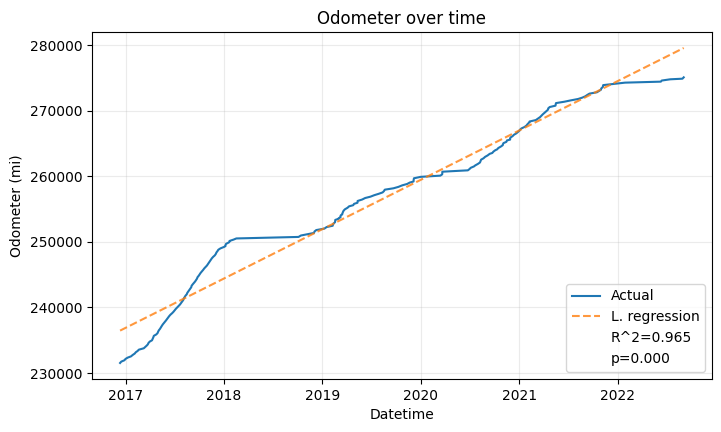

In [10]:

# dict to store linear regression data
model_dict = {}

slope, intercept, r_value, p_value, std_err = linregress(
    df.iloc[1:].timestamp, df.iloc[1:].odometer
)

model_dict["odometer"] = (slope, intercept, r_value, p_value, std_err)

fig, ax1 = plt.subplots(figsize=fig_size)
ax1.plot(df.index, df.odometer, label="Actual")
ax1.plot(
    df.index,
    intercept + slope * df.timestamp,
    color="tab:orange",
    alpha=0.8,
    linestyle="--",
    label="L. regression",
)
# invisible plots to put R and p on legend
ax1.plot(df.index, df.odometer, alpha=0, label=f"R^2={r_value * r_value:.3f}")
ax1.plot(df.index, df.odometer, alpha=0, label=f"p={p_value:.3f}")
ax1.grid(alpha=0.25)
ax1.legend(loc="lower right")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Odometer (mi)")
ax1.set_title("Odometer over time")


 ### Miles before fill up

 The number of miles since the last fill up is called *trip* in the app.

 I'm not sure that you can draw strong conclusions this this data. Most of the time I wait until the fuel gauge approaches the red *almost empty* indicator before refueling, at somewhere between 200 and 250 miles.

 However, I may refuel significantly before reaching *almost empty* when doing something like a preemptive fill up before a long road trip. Stopping to get gas 10 minutes into a journey is a little bit of a buzz kill!

 Indeed we see most trips are over 200 miles. However, there are a fair number of trips below 200 miles, as low as 75!

 The median is slightly higher than the mean which indicates some of the low values are pulling down the average.

 Interestingly, the linear regression shows a downward trend in miles before fill up. However, the tiny R^2 value tells us the model does a very poor job of explaining the response variable miles between fill ups and the predictor variable, datetime.

 That makes sense, we acknowledged that refueling is opportunistic. We can see the high variance in the data on the scatter plot as well as the slight trend of fewer miles before filling up.

Text(0.5, 1.0, 'Miles before fill up over time')

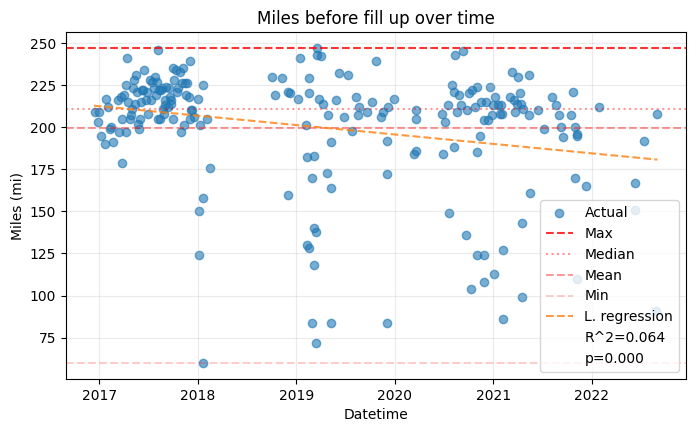

In [11]:

# start at index 1, no data in index 0
slope, intercept, r_value, p_value, std_err = linregress(
    df.iloc[1:].timestamp, df.iloc[1:].trip
)

model_dict["trip"] = (slope, intercept, r_value, p_value, std_err)

fig, ax1 = plt.subplots(figsize=fig_size)
ax1.scatter(df.index, df.trip, alpha=0.6, label="Actual")
ax1.axhline(y=trip_max, color="red", alpha=0.8, linestyle="--", label="Max")
ax1.axhline(y=trip_median, color="red", alpha=0.4, linestyle=":", label="Median")
ax1.axhline(y=trip_mean, color="red", alpha=0.4, linestyle="--", label="Mean")
ax1.axhline(y=trip_min, color="red", alpha=0.2, linestyle="--", label="Min")
ax1.plot(
    df.index,
    intercept + slope * df.timestamp,
    color="tab:orange",
    alpha=0.8,
    linestyle="--",
    label="L. regression",
)
ax1.plot(df.index, df.trip, alpha=0, label=f"R^2={r_value * r_value:.3f}")
ax1.plot(df.index, df.trip, alpha=0, label=f"p={p_value:.3f}")
ax1.grid(alpha=0.25)
ax1.legend(loc="lower right")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Miles (mi)")
ax1.set_title("Miles before fill up over time")


 ### Gallons filled

 Gallons filled should look somewhat similar to miles before fill up: fewer miles since last fill up should mean fewer gallons needed to fill up. In fact, that would be a good twin axis plot!

 The median is slightly higher than the mean, just like miles to refill.

 The linear regression trend line is remarkably flat and has exactly the same value as the mean. This means the intercept aka constant aka mean is effectively the only part of the model, there's no component of the predictor variable in the response variable.

Text(0.5, 1.0, 'Gallons per fill up over time')

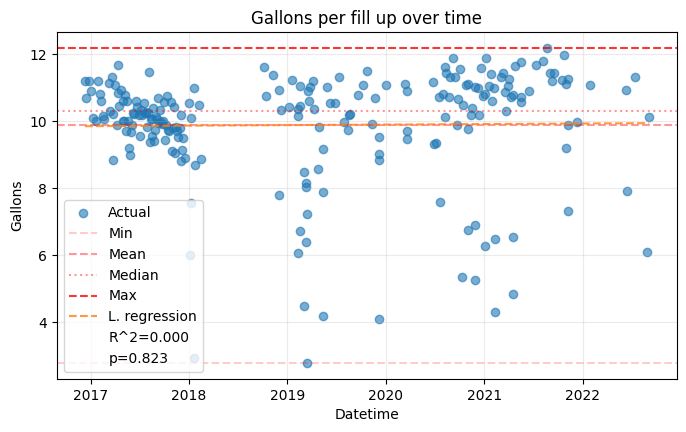

In [12]:

slope, intercept, r_value, p_value, std_err = linregress(
    df.iloc[1:].timestamp, df.iloc[1:].gallons
)

model_dict["gallons"] = (slope, intercept, r_value, p_value, std_err)

fig, ax1 = plt.subplots(figsize=fig_size)
ax1.scatter(df.index, df.gallons, alpha=0.6, label="Actual")
ax1.axhline(y=gallons_min, color="red", alpha=0.2, linestyle="--", label="Min")
ax1.axhline(y=gallons_mean, color="red", alpha=0.4, linestyle="--", label="Mean")
ax1.axhline(y=gallons_median, color="red", alpha=0.4, linestyle=":", label="Median")
ax1.axhline(y=gallons_max, color="red", alpha=0.8, linestyle="--", label="Max")
ax1.plot(
    df.index,
    intercept + slope * df.timestamp,
    color="tab:orange",
    alpha=0.8,
    linestyle="--",
    label="L. regression",
)
ax1.plot(df.index, df.gallons, alpha=0, label=f"R^2={r_value * r_value:.3f}")
ax1.plot(df.index, df.gallons, alpha=0, label=f"p={p_value:.3f}")
ax1.grid(alpha=0.25)
ax1.legend(loc="lower left")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Gallons")
ax1.set_title("Gallons per fill up over time")


 ### Miles before fill up and gallons filled over time

 We expect to see strong positive correlation between miles before fill up and gallons filled: low miles should mean low gallons.

 To compare miles since fill up and gallons filled, look at the blue and orange values with the same x or datetime value or on the same vertical line. We can confirm our hypothesis visually: fewer miles since last fill up means fewer gallons are required to fill up.

 Since we know that there is almost no correlation between datetime and miles since fill up or gallons filled, maybe we should plot miles since fill up versus gallons filled!

Text(0.5, 1.0, 'Miles since fill up vs gallons over time')

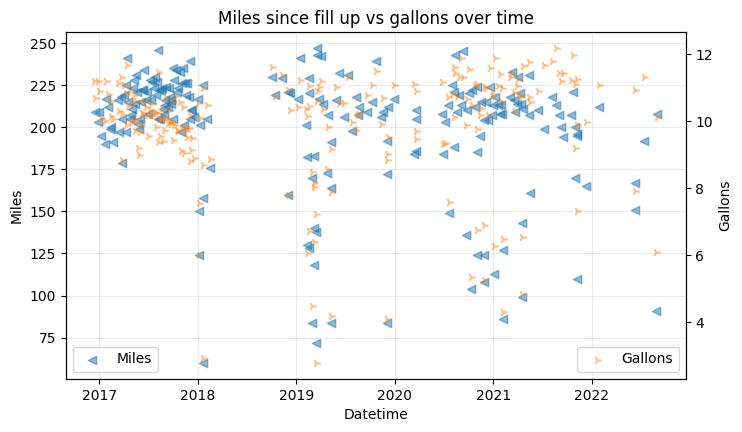

In [13]:

slope, intercept, r_value, p_value, std_err = linregress(
    df.iloc[1:].timestamp, df.iloc[1:].gallons
)

model_dict["gallons"] = (slope, intercept, r_value, p_value, std_err)

fig, ax1 = plt.subplots(figsize=fig_size)
ax1.scatter(df.index, df.trip, alpha=0.5, marker="<", label="Miles")
ax2 = ax1.twinx()
ax2.scatter(
    df.index, df.gallons, color="tab:orange", alpha=0.5, marker="4", label="Gallons"
)
ax1.grid(alpha=0.25)
ax1.legend(loc="lower left")
ax2.legend(loc="lower right")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Miles")
ax2.set_ylabel("Gallons")
ax1.set_title("Miles since fill up vs gallons over time")


## Miles since fill up vs gallons filled

 If we set miles since fill up as the independent variable and gallons filled as the dependent variable we see a clear trend: more miles means more gallons.

 The linear regression has an R^2 value of 0.782 which tells us the model does a moderate job of predicting the gallons filled.

 This makes sense, the bulk of the gallons filled is defined by how many miles were driven but there is still some influence from other variables which may include things like driving conditions and season.

Text(0.5, 1.0, 'Miles since fill up vs gallons filled')

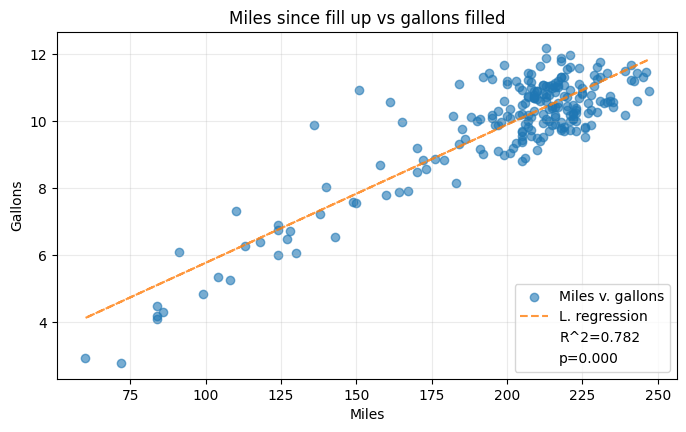

In [14]:

slope, intercept, r_value, p_value, std_err = linregress(
    df.iloc[1:].trip, df.iloc[1:].gallons
)

model_dict["gallons"] = (slope, intercept, r_value, p_value, std_err)

fig, ax1 = plt.subplots(figsize=fig_size)
ax1.scatter(df.trip, df.gallons, alpha=0.6, label="Miles v. gallons")
ax1.plot(
    df.trip,
    intercept + slope * df.trip,
    color="tab:orange",
    alpha=0.8,
    linestyle="--",
    label="L. regression",
)
ax1.plot(df.trip, df.gallons, alpha=0, label=f"R^2={r_value * r_value:.3f}")
ax1.plot(df.trip, df.gallons, alpha=0, label=f"p={p_value:.3f}")
ax1.grid(alpha=0.25)
ax1.legend(loc="lower right")
ax1.set_xlabel("Miles")
ax1.set_ylabel("Gallons")
ax1.set_title("Miles since fill up vs gallons filled")


## Fuel price

 There are some interesting insights hiding in the gas price over time!

 1. I drove the most in 2017 and late 2020 as we saw in the odometer plot
 2. Price generally goes up over time
 3. Price dropped dramatically during early covid
 4. Price jumped dramatically after the invasion of Ukraine
 5. There are some high outliers in 2018 and 2019

 My thought is that the outliers were fill ups at remote gas stations, likely on a road trip. This would be interesting to take a deeper look at!

Text(0.5, 1.0, 'Fuel price over time')

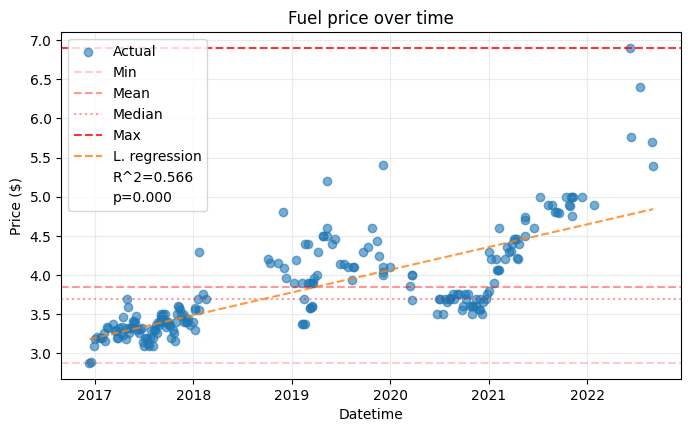

In [15]:

slope, intercept, r_value, p_value, std_err = linregress(
    df.iloc[1:].timestamp, df.iloc[1:].price
)

model_dict["price"] = (slope, intercept, r_value, p_value, std_err)

fig, ax1 = plt.subplots(figsize=fig_size)
ax1.scatter(df.index, df.price, alpha=0.6, label="Actual")
ax1.axhline(y=price_min, color="red", alpha=0.2, linestyle="--", label="Min")
ax1.axhline(y=price_mean, color="red", alpha=0.4, linestyle="--", label="Mean")
ax1.axhline(y=price_median, color="red", alpha=0.4, linestyle=":", label="Median")
ax1.axhline(y=price_max, color="red", alpha=0.8, linestyle="--", label="Max")
ax1.plot(
    df.index,
    intercept + slope * df.timestamp,
    color="tab:orange",
    alpha=0.8,
    linestyle="--",
    label="L. regression",
)
ax1.plot(df.index, df.price, alpha=0, label=f"R^2={r_value * r_value:.3f}")
ax1.plot(df.index, df.price, alpha=0, label=f"p={p_value:.3f}")
ax1.grid(alpha=0.25)
ax1.legend(loc="upper left")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Price ($)")
ax1.set_title("Fuel price over time")


 ### Mileage

 The mileage data is all over the place, but we can say:

 1. Mileage has a pretty wide spread even at similar datetimes
 2. Mileage generally trends down over time
 3. There is an interesting upward trend in 2017
 4. There is a single 26 mpg outlier at 3.2 standard deviations from the mean (that we will investigate later)

 The R^2 value indicates that this model does a pretty poor job of predicting mileage based on datetime.

 Hopefully this is sounding like a broken record by now, but this makes sense. Things like driving conditions and vehicle condition dominate mileage especially relative to datetime.

mileage max outlier: 3.2 standard deviations from mean


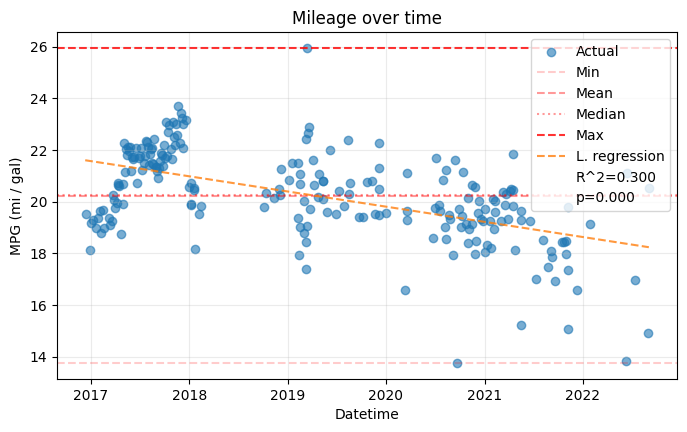

In [16]:

slope, intercept, r_value, p_value, std_err = linregress(
    df.iloc[1:].timestamp, df.iloc[1:].mpg
)

model_dict["mpg"] = (slope, intercept, r_value, p_value, std_err)

fig, ax1 = plt.subplots(figsize=fig_size)
ax1.scatter(df.index, df.mpg, alpha=0.6, label="Actual")
ax1.axhline(y=mpg_min, color="red", alpha=0.2, linestyle="--", label="Min")
ax1.axhline(y=mpg_mean, color="red", alpha=0.4, linestyle="--", label="Mean")
ax1.axhline(y=mpg_median, color="red", alpha=0.4, linestyle=":", label="Median")
ax1.axhline(y=mpg_max, color="red", alpha=0.8, linestyle="--", label="Max")
ax1.plot(
    df.index,
    intercept + slope * df.timestamp,
    color="tab:orange",
    alpha=0.8,
    linestyle="--",
    label="L. regression",
)
ax1.plot(df.index, df.mpg, alpha=0, label=f"R^2={r_value * r_value:.3f}")
ax1.plot(df.index, df.mpg, alpha=0, label=f"p={p_value:.3f}")
ax1.grid(alpha=0.25)
ax1.legend(loc="upper right")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("MPG (mi / gal)")
ax1.set_title("Mileage over time")

print(
    f"mileage max outlier: {(mpg_max - mpg_mean) / mpg_std:.1f} standard deviations from mean"
)


 ### Fill ups per month

 We will eventually look at mileage per month, but I wanted to take a look at the number of fill ups and miles traveled per month in order to understand how much we can draw conclusions from the mileage per month data.

 First, we'll take a look at fill ups per month.

 March had the largest number of fill ups at 25 and June had the least at 14, but in general the number of fill ups per month is close to the mean value of 18.25. It looks like there is enough data to draw conclusions from the mileage per month data.

Text(0.5, 1.0, 'Suzuki fill ups per month')

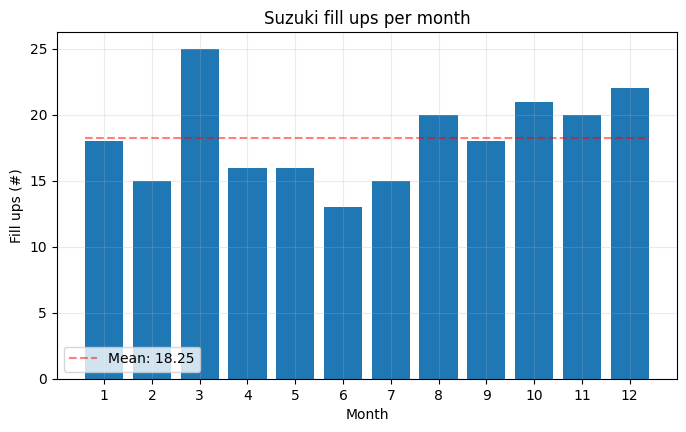

In [17]:

fill_up_mean = df.groupby(df.index.month).count().gallons.mean()

fig, ax1 = plt.subplots(figsize=fig_size)
ax1.bar([*range(1, 12 + 1)], df.groupby(df.index.month).count().gallons)
ax1.hlines(
    fill_up_mean,
    0.6,
    12.4,
    alpha=0.5,
    linestyle="--",
    color="red",
    label=f"Mean: {fill_up_mean}",
)
ax1.grid(alpha=0.25)
ax1.legend(loc="lower left")
ax1.set_xlabel("Month")
ax1.set_ylabel("Fill ups (#)")
ax1.set_xticks(range(1, 12 + 1))
ax1.set_title("Suzuki fill ups per month")


 ### Miles per month

 Another way to look at the vehicle usage per month is looking at the sum of the miles since fill up. We would expect this to be highly correlated to the number of fill ups per month -- and it is!

 This might be another relationship worth exploring.

Text(0.5, 1.0, 'Suzuki miles per month')

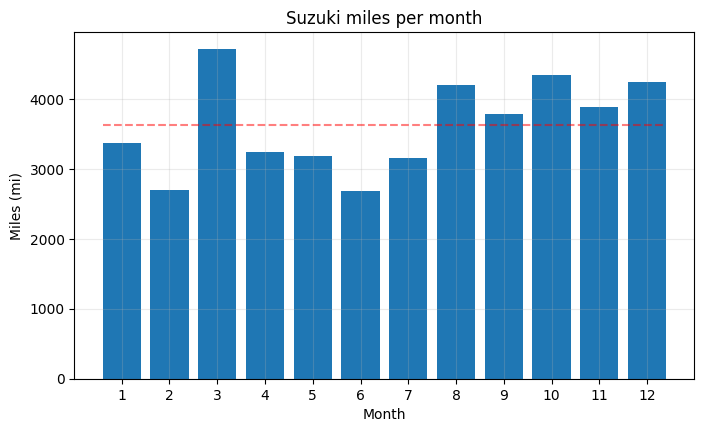

In [18]:

trip_sum_mean = df.groupby(df.index.month).sum().trip.mean()

fig, ax1 = plt.subplots(figsize=fig_size)
ax1.bar([*range(1, 12 + 1)], df.groupby(df.index.month).sum().trip)
ax1.hlines(
    trip_sum_mean,
    0.6,
    12.4,
    alpha=0.5,
    linestyle="--",
    color="red",
    label=f"Mean: {trip_sum_mean}",
)
ax1.grid(alpha=0.25)
ax1.set_xlabel("Month")
ax1.set_ylabel("Miles (mi)")
ax1.set_xticks(range(1, 12 + 1))
ax1.set_title("Suzuki miles per month")


 ### Fill ups per month versus miles per month

 If we set number of fill ups as the independent variable and number of miles as the dependent variable we see a very strong trend.

 The R^2 is a whopping 0.925, indicating that the model strongly predicts how many miles are traveled based on the number of fill ups.

 This makes sense, more fill ups means more miles. The number of miles will vary with mileage. However, since the standard deviation of mileage is relatively small at 1.76, the number of miles traveled per fill up won't vary significantly.

Text(0.5, 1.0, 'Fill ups per month versus miles per month')

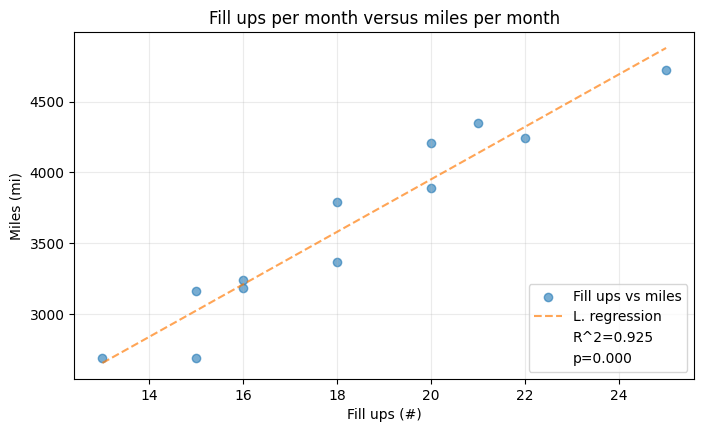

In [19]:

slope, intercept, r_value, p_value, std_err = linregress(
    df.groupby(df.index.month).count().gallons, df.groupby(df.index.month).sum().trip
)

# model_dict["gallons"] = (slope, intercept, r_value, p_value, std_err)

fig, ax1 = plt.subplots(figsize=fig_size)
ax1.scatter(
    df.groupby(df.index.month).count().gallons,
    df.groupby(df.index.month).sum().trip,
    alpha=0.6,
    label="Fill ups vs miles",
)
ax1.plot(
    sorted(df.groupby(df.index.month).count().gallons.to_numpy()),
    intercept
    + np.multiply(slope, sorted(df.groupby(df.index.month).count().gallons.to_numpy())),
    color="tab:orange",
    alpha=0.7,
    linestyle="--",
    label="L. regression",
)
ax1.plot(
    df.groupby(df.index.month).count().gallons,
    df.groupby(df.index.month).sum().trip,
    alpha=0,
    label=f"R^2={r_value * r_value:.3f}",
)
ax1.plot(
    df.groupby(df.index.month).count().gallons,
    df.groupby(df.index.month).sum().trip,
    alpha=0,
    label=f"p={p_value:.3f}",
)
ax1.grid(alpha=0.25)
ax1.legend(loc="lower right")
ax1.set_xlabel("Fill ups (#)")
ax1.set_ylabel("Miles (mi)")
ax1.set_title("Fill ups per month versus miles per month")


 ### Mileage per month

 Finally we will look in to my original question: is there any seasonality to the mileage?

 We can overlay the maximum, mean, and minimum mileage per month to get an idea of the average as well as extremes.

 There is just one outlier, the previously mentioned 26 mi / gal tank.

 There is significant month to month variation on the minimum mileage numbers. This would likely be caused using 4 wheel drive while driving off-road, which decreases mileage significantly.

 Other than the March outlier, the maximum mileage numbers follow a slight trend of increasing from a minimum in January to a maximum in November. It seems strange that January is significantly higher than December.

 However, keep in mind since this is a maximum, all that's required is a single fill up to achieve a new maximum. The maximum data shouldn't be used for general insights into the data.

 The mean takes into account all of the fill ups in the month, which means we can put some weight into the insights and trends observed.

 There seems to be a slight trend where spring and early summer months have the highest mileage and the winter has the lowest mileage.

 June seems to be slightly lower than the trend. June also has one of the lowest minimums, it could be the case that June has good weather for driving off-road, which drags down the mean mileage.

 September also has low mean and minimum mileage. This could be from driving off-road or maybe lots of air conditioner usage during hot summer months.

 #### Conclusion on seasonality of mileage

 My original hypothesis was that the mean mileage would be lower in winter than summer. The variation may be small (the max - min mean mileage is around 1 mpg), but it does seem to be the case that the mean mileage may be slightly higher in the summer than winter.

 Imagine if we could take any air conditioner usage, which would (unfairly) drag down the summer mileage.

(max - min) mean mileage: 1.05 mpg


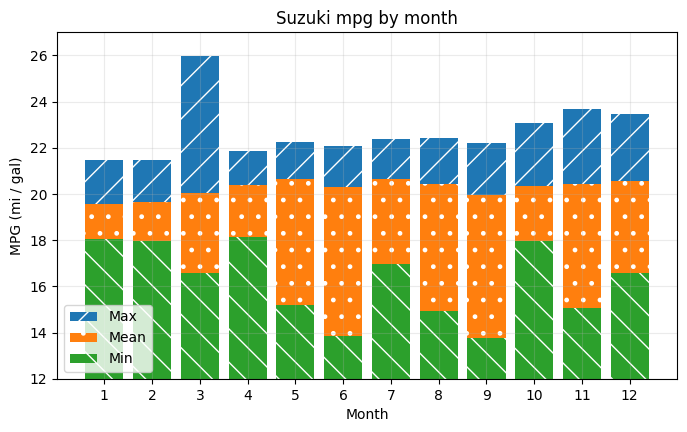

In [20]:

fig, ax1 = plt.subplots(figsize=fig_size)
ax1.bar(
    [*range(1, 12 + 1)],
    df.groupby(df.index.month).max(numeric_only=True).mpg,
    label="Max",
    hatch="/",
    edgecolor="white",
    linewidth=0,
)
ax1.bar(
    [*range(1, 12 + 1)],
    df.groupby(df.index.month).mean(numeric_only=True).mpg,
    label="Mean",
    hatch=".",
    edgecolor="white",
    linewidth=0,
)
ax1.bar(
    [*range(1, 12 + 1)],
    df.groupby(df.index.month).min(numeric_only=True).mpg,
    label="Min",
    hatch="\\",
    edgecolor="white",
    linewidth=0,
)
ax1.grid(alpha=0.25)
ax1.legend(loc="lower left")
ax1.set_ylim(mpg_lim[0], mpg_lim[1])
ax1.set_xlabel("Month")
ax1.set_ylabel("MPG (mi / gal)")
ax1.set_xticks(range(1, 12 + 1))
ax1.set_title("Suzuki mpg by month")

print(
    f"(max - min) mean mileage: {df.groupby(df.index.month).mean(numeric_only=True).mpg.max() - df.groupby(df.index.month).mean(numeric_only=True).mpg.min():.2f} mpg"
)


 ### Import California map

 I wanted to create a geo scatter plot with the location of each fill up on a map of California where all of the driving occurred. I was able to locate a California counties shape file here: https://data.edd.ca.gov/api/geospatial/grn2-ffzq?method=export&format=Shapefile

In [21]:

ca_counties = gpd.read_file("California Counties")
ca_counties.to_crs(epsg="4326", inplace=True)


 ### Enter geopandas

 *geopandas* is a package to work with geographic data like our latitude, longitude fill up locations easier to work with.

 First, we'll create a *geopandas dataframe* from the original *dataframe's* lon, lat columns. Any rows without lon, lat values are invalid and dropped.

 Next, we'll calculate the distance between each fill up location and 3 places I lived during the duration of this data collection: La Jolla, San Francisco, and San Diego.

 We also calculate the minimum (and index) of these 3 distances for each fill up. This will allow us to classify fill ups as in-town or road trips, which could be interesting.

 The finished *geopandas dataframe* is displayed.

In [22]:

gdf = gpd.GeoDataFrame(
    df.dropna(),
    geometry=gpd.points_from_xy(df.dropna().lon, df.dropna().lat, crs="EPSG:4326"),
)
gdf = gdf.to_crs(epsg=32663)

gdf["lj_mi"] = gdf.distance(lj_home).apply(m_to_mi)
gdf["sf_mi"] = gdf.distance(sf_home).apply(m_to_mi)
gdf["sd_mi"] = gdf.distance(sd_home).apply(m_to_mi)

gdf["min_mi"] = gdf[["lj_mi", "sf_mi", "sd_mi"]].min(axis=1)
gdf["min_mi_idx"] = gdf[["lj_mi", "sf_mi", "sd_mi"]].idxmin(axis=1)

# convert back to EPSG-4326 for display
gdf = gdf.to_crs(epsg=4326)

# print gdf
gdf


,odometer,trip,gallons,price,total_price,mpg,lat,lon,timestamp,geometry,lj_mi,sf_mi,sd_mi,min_mi,min_mi_idx
date,,,,,,,,,,,,,,,
2016-12-27 11:16:00,231932,203.0,11.200,3.0893,34.60,18.1250,32.836524,-117.152631,1.482837e+09,POINT (-117.15263 32.83652),6.799270,499.301655,14.099569,6.799270,lj_mi
2016-12-31 19:49:00,232141,209.0,10.900,3.1872,34.74,19.1743,32.838751,-117.278172,1.483214e+09,POINT (-117.27817 32.83875),2.098278,492.891716,19.064945,2.098278,lj_mi
2017-01-08 17:20:00,232336,195.0,10.100,3.2139,32.46,19.3069,32.832988,-117.163933,1.483896e+09,POINT (-117.16393 32.83299),6.068487,498.898648,14.637008,6.068487,lj_mi
2017-01-20 22:19:00,232526,190.0,10.000,3.2020,32.02,19.0000,32.937711,-117.112836,1.484951e+09,POINT (-117.11284 32.93771),11.261682,496.576636,6.580640,6.580640,sd_mi
2017-01-27 07:55:00,232743,217.0,11.200,3.1946,35.78,19.3750,32.937623,-117.112793,1.485504e+09,POINT (-117.11279 32.93762),11.260911,496.582932,6.585044,6.585044,sd_mi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-09 19:31:00,274402,151.0,10.919,6.8990,75.33,13.8291,38.249416,-122.626582,1.654803e+09,POINT (-122.62658 38.24942),527.065964,36.054636,527.307640,36.054636,sf_mi
2022-06-12 15:32:00,274569,167.0,7.911,5.7667,45.62,21.1098,37.929562,-122.516417,1.655048e+09,POINT (-122.51642 37.92956),506.114647,12.824497,506.712935,12.824497,sf_mi
2022-07-14 14:27:00,274761,192.0,11.320,6.3993,72.44,16.9611,37.762638,-122.434588,1.657809e+09,POINT (-122.43459 37.76264),494.044458,1.008698,494.801363,1.008698,sf_mi


 ### California mileage

 We can look at the location of each fill up as well as the mileage indicated by each marker color. Lower mileages are darker blue, followed by greens for moderate values, and yellow for the highest mileage.

 We can see our 26 mileage outlier in the Northern California. In fact, this looks like it is on the highway between my home in San Francisco and snow sports in Lake Tahoe.

 My guess is that the previous fill up was done in the Lake Tahoe area and the driving was downhill back to San Francisco. In this case, physics was on my side and provided an extra boost to mileage.

 We can investigate this high mileage outlier filtering by rows where mpg is greater than 25.

 If we look at the trip column we see 72 miles, a total of 2.8 gallon filled, and 26.0 mileage. This is well below the 12.2 gallons max and 9.9 gallons mean filled.

 This means it was less than a third of a tank, likely down hill from Lake Tahoe, that generated the 26 mileage outlier.

 If we look at the fill previous to the 26 mileage outlier, we can see it was earlier that same day. I don't remember why I filled up after just 72 miles, it must have been a convenient pit stop!

Fill ups with mileage over 25:


,odometer,trip,gallons,price,total_price,mpg,lat,lon,timestamp
date,,,,,,,,,
2019-03-15 16:04:00,254234,72.0,2.774,3.5977,9.98,25.9553,38.489856,-121.804623,1.552666e+09


Fill up previous to fill up over 25 mileage:


,odometer,trip,gallons,price,total_price,mpg,lat,lon,timestamp
date,,,,,,,,,
2019-03-15 13:06:00,254162,138.0,7.233,3.8988,28.2,19.0792,37.777246,-122.404422,1.552655e+09


Max fill up in gallons (tank size estimate): 12.2
Mean fill up in gallons: 9.9


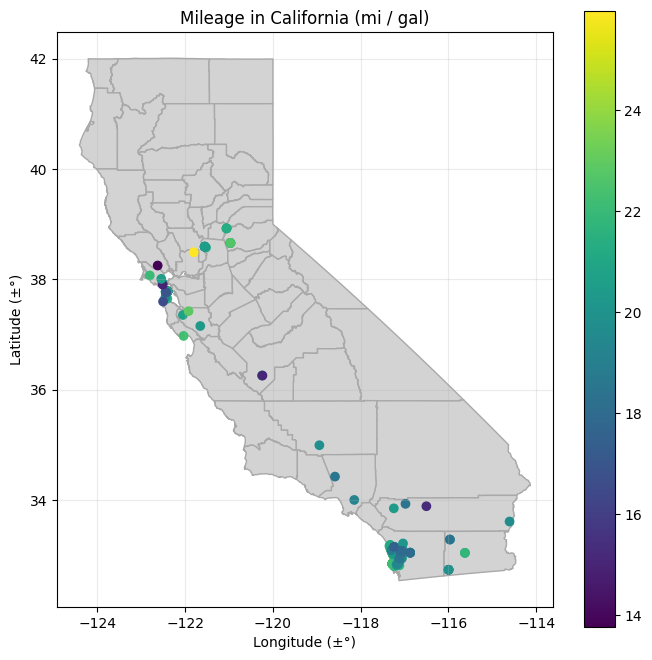

In [23]:

fig, ax = plt.subplots(figsize=(fig_size[0], fig_size[0]))

ca_counties.plot(ax=ax, color="lightgrey", edgecolor="darkgrey")
gdf.plot(ax=ax, aspect=None, column="mpg", legend=True)

ax.set_title("Mileage in California (mi / gal)")
ax.set_xlabel("Longitude (±°)")
ax.set_ylabel("Latitude (±°)")
ax.grid(alpha=0.25)

print("Fill ups with mileage over 25:")
# use display() to print multiple df with pretty formatting
display(df[df.mpg > 25])
print("Fill up previous to fill up over 25 mileage:")
display(df.iloc[[df.index.get_loc(df[df.mpg > 25].index[0]) - 1]])
print(f"Max fill up in gallons (tank size estimate): {gallons_max:.1f}")
print(f"Mean fill up in gallons: {gallons_mean:.1f}")


 ### San Diego mileage

 Zooming in to the San Diego fill up locations, we can see the majority are in San Diego County, followed by some in Riverside county. There are some additional fill ups in the eastern Imperial County (not shown).

 You can start to see some of the common routes I drove along Interstate 5 (coastal) and Interstate 15 (inland).

 It sort of looks like the coastal fill ups have a brighter green color, indicating slightly higher mileage.

 The inland fill ups have a darker color, indicating slightly lower mileage. The fill up in the upper right has the darkest color indicating the lowest mileage. This was likely after a day of off-road driving!

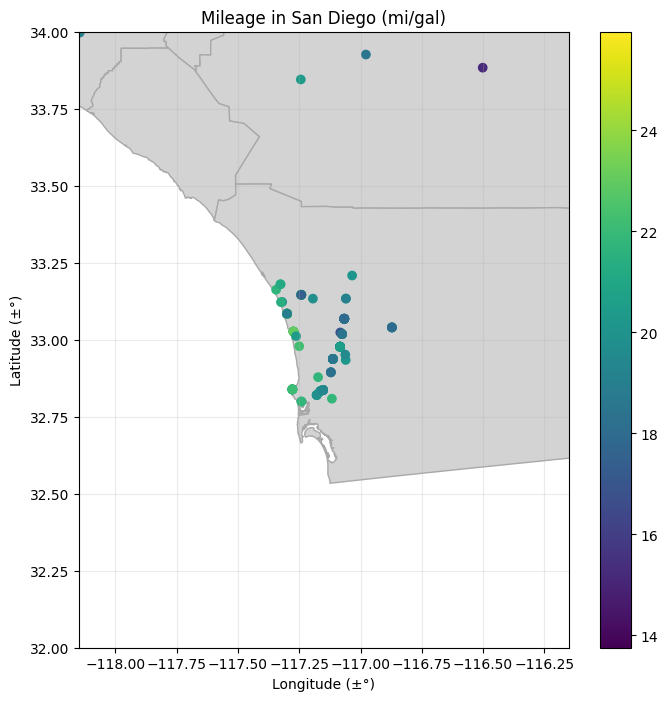

In [24]:

fig, ax = plt.subplots(figsize=(fig_size[0], fig_size[0]))

ca_counties.plot(ax=ax, color="lightgrey", edgecolor="darkgrey")
gdf.plot(ax=ax, aspect=None, column="mpg", legend=True)

ax.set_title("Mileage in San Diego (mi/gal)")
ax.set_xlabel("Longitude (±°)")
ax.set_ylabel("Latitude (±°)")
ax.set_xlim([-118.15, -116.15])
ax.set_ylim([32, 34])
ax.grid(alpha=0.25)


 ### San Francisco mileage

 When we zoom in to the San Francisco Bay Area, we see a cluster around San Francisco with some fill ups in Marin, South Bay, and Lake Tahoe. We can see our 26 mileage outlier between Lake Tahoe and San Francisco.

 The lowest mileage fill ups seem disbursed between San Francisco, Marin, Pacifica, and somewhere along Interstate 5 in the central valley.

 There is a little bit of contrast between San Diego and San Francisco where road trips from San Diego have lower mileage and road trips from San Francisco have higher mileage.

 One interesting bit is that I would drive off-road often in San Diego, but never in San Francisco.

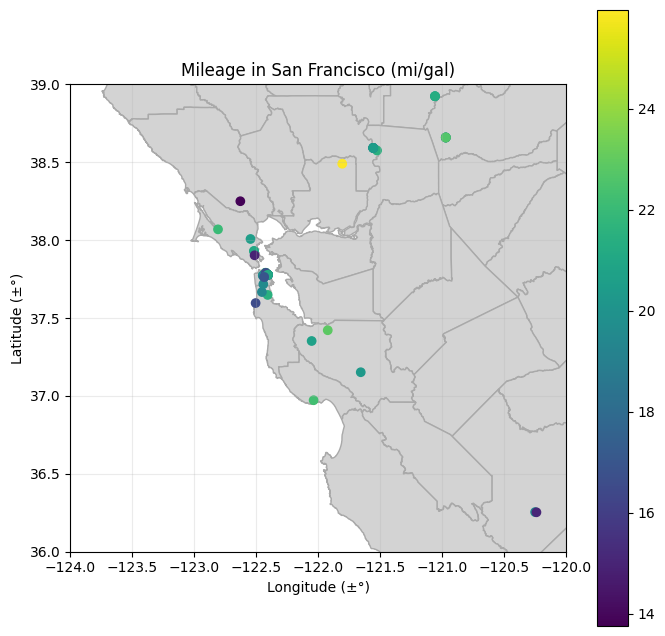

In [25]:

fig, ax = plt.subplots(figsize=(fig_size[0], fig_size[0]))

ca_counties.plot(ax=ax, color="lightgrey", edgecolor="darkgrey")
gdf.plot(ax=ax, aspect=None, column="mpg", legend=True)

ax.set_title("Mileage in San Francisco (mi/gal)")
ax.set_xlabel("Longitude (±°)")
ax.set_ylabel("Latitude (±°)")
ax.set_xlim([-124, -120])
ax.set_ylim([36, 39])
ax.grid(alpha=0.25)


## Distance and mileage

 We made some casual observations about the distance from home versus the mileage, we should take a look at the data to confirm!

 The first plot is the whole data set including 2 homes in San Diego and 1 in San Francisco.

 After seeing just the scatter plot we get a pretty good idea that the linear regression model won't be very good. There's no real trend, other than that there are significantly more fill ups closer to home than further away. However, the mileage is all over the place.

 Sure enough, the R^2 is effectively 0 and the massive p value of 0.355 means we fail to reject the null hypothesis.

 We made different observations on the San Diego data versus Bay Area data, so we should take a peek at each specific case.

 Data from the first home in La Jolla is shown in blue, the second in San Francisco is shown in orange, and the third in San Diego is shown in green.

 As mentioned earlier, the region less than 25 miles from home is very dense, while the rest is very sparse. This could be remedied by using a log scale on the x-axis, which would give the shorter distance from home more room to breath and squish down the higher distances from home.

 This plot is wonderful! We can see various fill ups at the same gas station by looking at the markers in a straight vertical line, with the same x distance from home value. We can see significant spread in mileage even at the same gas station. This confirms that the linear regression model isn't useful.

 If we squint just right, we could probably say that at high distances from home, the San Francisco data seems to skew slightly higher than San Diego, but it's not a particularly strong insight.

Text(0.5, 1.0, 'Distance from home versus mileage per home')

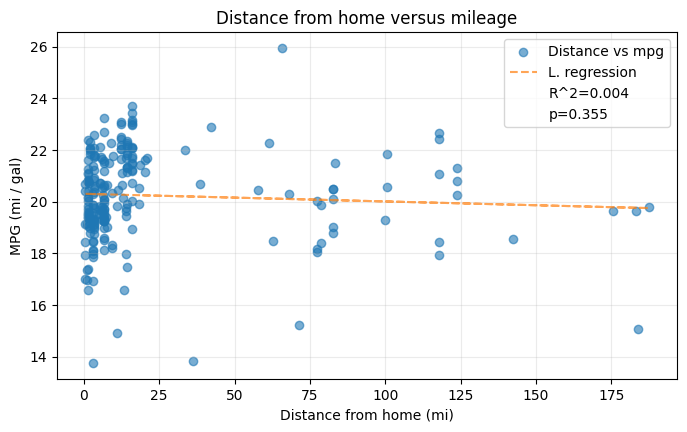

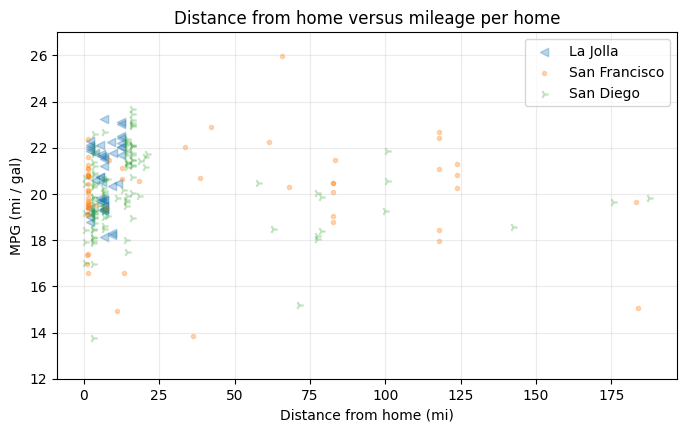

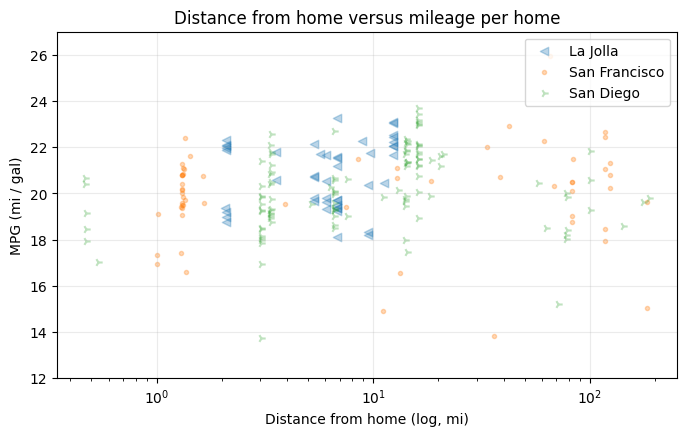

In [26]:

slope, intercept, r_value, p_value, std_err = linregress(gdf.min_mi, gdf.mpg)

fig, ax1 = plt.subplots(figsize=fig_size)
ax1.scatter(
    gdf.min_mi,
    gdf.mpg,
    alpha=0.6,
    label="Distance vs mpg",
)
ax1.plot(
    gdf.min_mi,
    intercept + slope * gdf.min_mi,
    color="tab:orange",
    alpha=0.7,
    linestyle="--",
    label="L. regression",
)
ax1.plot(
    gdf.min_mi,
    gdf.mpg,
    alpha=0,
    label=f"R^2={r_value * r_value:.3f}",
)
ax1.plot(
    gdf.min_mi,
    gdf.mpg,
    alpha=0,
    label=f"p={p_value:.3f}",
)
ax1.grid(alpha=0.25)
ax1.legend(loc="upper right")
ax1.set_xlabel("Distance from home (mi)")
ax1.set_ylabel("MPG (mi / gal)")
ax1.set_title("Distance from home versus mileage")

# plot distance from home versus mileage, per home

fig, ax1 = plt.subplots(figsize=fig_size)
ax1.scatter(
    gdf[(gdf["min_mi_idx"] == "lj_mi")].min_mi,
    gdf[(gdf["min_mi_idx"] == "lj_mi")].mpg,
    alpha=0.3,
    label="La Jolla",
    marker="<",
)
ax1.scatter(
    gdf[(gdf["min_mi_idx"] == "sf_mi")].min_mi,
    gdf[(gdf["min_mi_idx"] == "sf_mi")].mpg,
    alpha=0.3,
    label="San Francisco",
    marker=".",
)
ax1.scatter(
    gdf[(gdf["min_mi_idx"] == "sd_mi")].min_mi,
    gdf[(gdf["min_mi_idx"] == "sd_mi")].mpg,
    alpha=0.3,
    label="San Diego",
    marker="4",
)
ax1.grid(alpha=0.25)
ax1.legend(loc="upper right")
ax1.set_ylim(mpg_lim[0], mpg_lim[1])
ax1.set_xlabel("Distance from home (mi)")
ax1.set_ylabel("MPG (mi / gal)")
ax1.set_title("Distance from home versus mileage per home")

# plot distance from home versus mileage, log x, per home
fig, ax1 = plt.subplots(figsize=fig_size)

ax1.scatter(
    gdf[(gdf["min_mi_idx"] == "lj_mi")].min_mi,
    gdf[(gdf["min_mi_idx"] == "lj_mi")].mpg,
    alpha=0.3,
    label="La Jolla",
    marker="<",
)
ax1.scatter(
    gdf[(gdf["min_mi_idx"] == "sf_mi")].min_mi,
    gdf[(gdf["min_mi_idx"] == "sf_mi")].mpg,
    alpha=0.3,
    label="San Francisco",
    marker=".",
)
ax1.scatter(
    gdf[(gdf["min_mi_idx"] == "sd_mi")].min_mi,
    gdf[(gdf["min_mi_idx"] == "sd_mi")].mpg,
    alpha=0.3,
    label="San Diego",
    marker="4",
)
ax1.set_xscale("log")
ax1.grid(alpha=0.25)
ax1.legend(loc="upper right")
ax1.set_ylim(mpg_lim[0], mpg_lim[1])
ax1.set_xlabel("Distance from home (log, mi)")
ax1.set_ylabel("MPG (mi / gal)")
ax1.set_title("Distance from home versus mileage per home")


 ### Conclusion

 I set out to achieve 3 goals:

 1. Determine any seasonality of mileage

 We showed that there is some seasonality in mileage, it is slightly worse in the winter than summer. The seasonality could be from oxygenated gas in winter or from less off-road driving in summer.

 2. Interview take home project

 I really like this data for a take home analysis:

 1. It's a real-world data
 2. It's a small at 29 kB (including the discarded maintenance information)
 3. It requires a just a little bit of cleaning
 4. There are so many ways to slice and present the data

 I spent more time than expected on this, way more than I would expect from a candidate. I look forward to seeing what people submit if I am ever able to use this as a take home problem.

 3. Learning / mentoring / sharing

 I learned a thing or two doing this analysis:

 1. Linear regression including R^2 and p values. It's too bad I couldn't come up with a multi-variant model
 2. *geopandas* including distance and even minimum distance calculations
 3. How to use `# %% [markdown]` to turn comments within a cell into markdown
     1. This allows me to use .py files just like a Jupyter notebook
     2. Using .py allows me to autoformat code upon saving with Python black
     3. I also can use text editor features that aren't supported in Jupyter
 4. I learned a lot about my Suzuki and my driving habits between San Diego and San Francisco
 5. The version of the *Tableau 10* default color palette in Matplotlib is not very accessible
     1. Thanks [Marian](https://github.com/mmdski)!
     2. You can see Tableau's updated palette [here](https://www.tableau.com/blog/colors-upgrade-tableau-10-56782)

 I don't know that any of these regression models are particularly useful. Maybe if I wanted to forecast fuel and / or maintenance costs. In this case, I would probably want to use a model that weights more recent driving heavier than older data since I have not been driving much.

 I spent a great deal of time on this write up so I could share and hopefully mentor people in data analysis.

 I hope you got some value and maybe even a little enjoyment out of this. -- Nick